# <a id='toc1_'></a>[**Integer Constrained Optimization: A Real Use Case**](#toc0_)
## <a id='toc1_1_'></a>[**A cafeteria in Munich**](#toc0_)

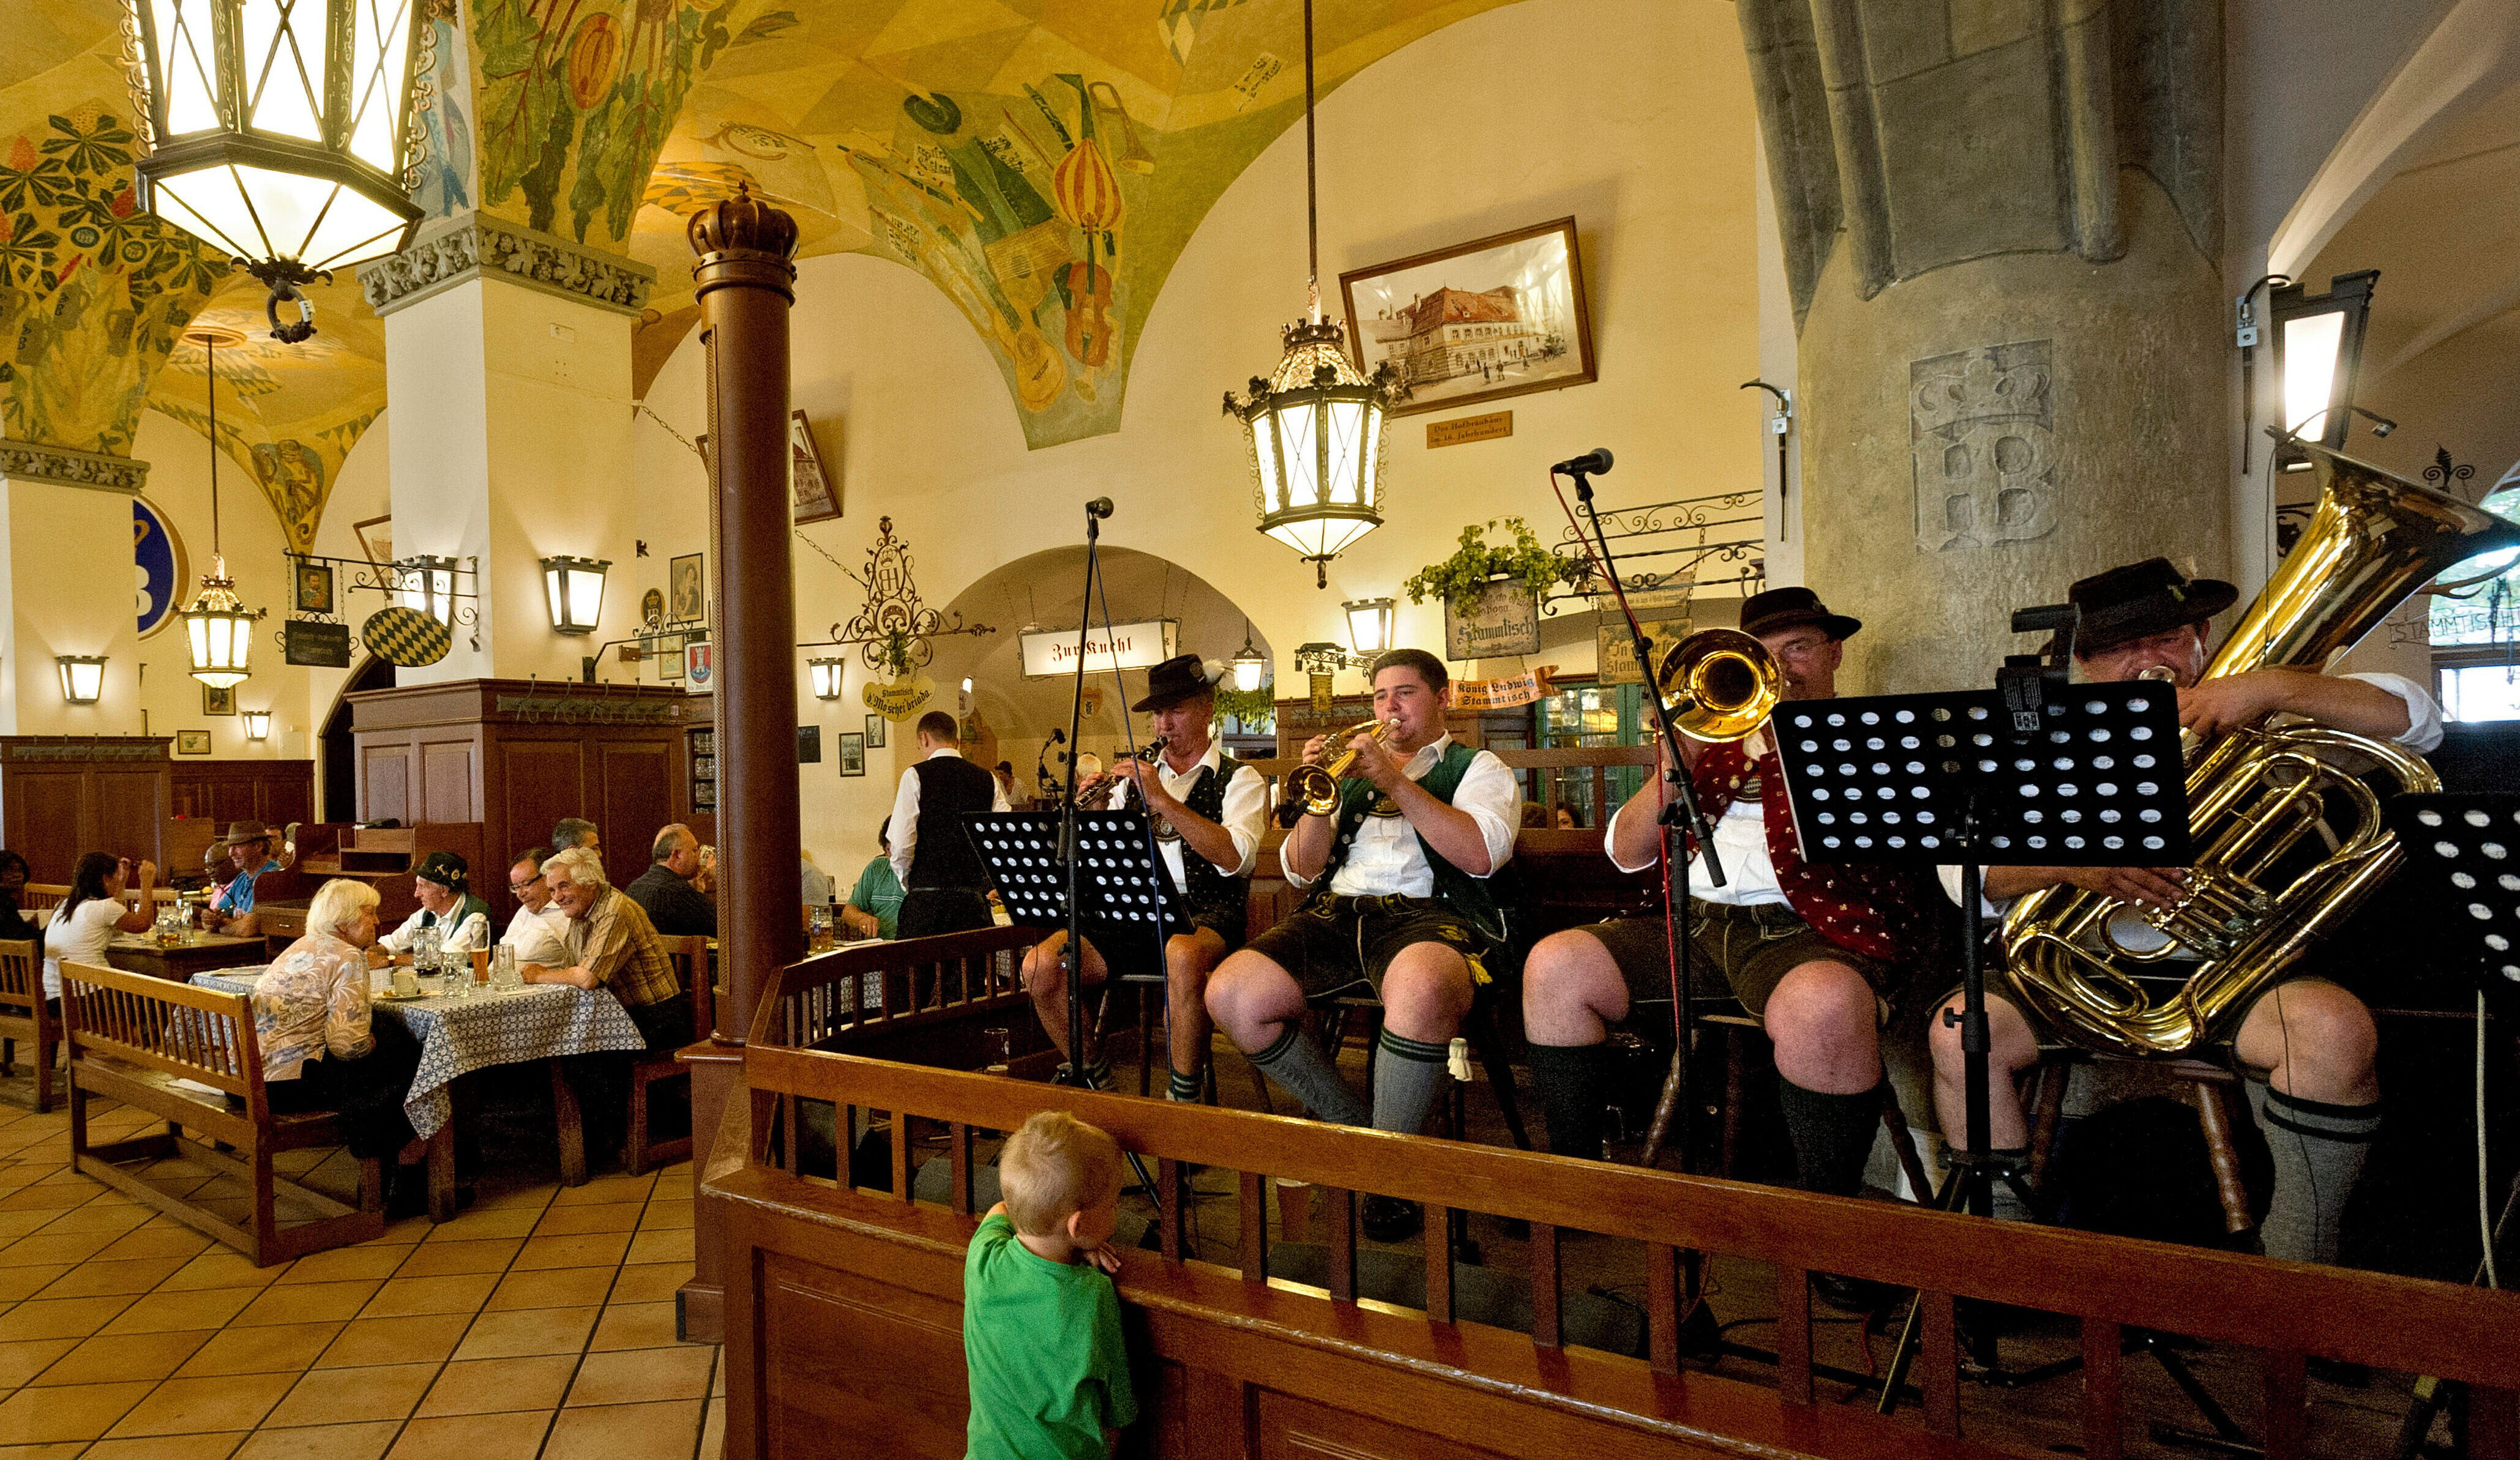

**Table of contents**<a id='toc0_'></a>    
- [**Integer Constrained Optimization: A Real Use Case**](#toc1_)    
  - [**A cafeteria in Munich**](#toc1_1_)    
- [Problem statement](#toc2_)    
- [Environment preparation](#toc3_)    
  - [Capturing our weather data](#toc3_1_)    
- [Time Series Analysis and Forecast](#toc4_)    
  - [Plot](#toc4_1_)    
  - [Checking for stationarity in the mean](#toc4_2_)    
  - [Checking Correlation and Autocorrelation](#toc4_3_)    
  - [Applying ARIMA](#toc4_4_)    
- [Integer constrained optimization apply to our demand (pyomo)](#toc5_)    
  - [Functions](#toc5_1_)    
- [Pyomo model Pipepline](#toc6_)    
- [Pyomo Recommendations for Cafe owner](#toc7_)    
- [print the values of the variables](#toc8_)    
- [print the values of the objective function](#toc9_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Problem statement](#toc0_)

We have a typically German cafeteria in Munich and we have noticed that our three top sellers are:

- Hot Wine
- Ice Cream
- Coffee

We want to maximise sales of these items taking into consideration production and demand constraints.

We have noticed furthermore, that these articles vary a lot with seasonality. For this reason, we are communicating with an API to retrieve the weahter for today and using an ARIMA model on data from the past year and a half, established forecasts to use in our demand planning pyomo function

# <a id='toc3_'></a>[Environment preparation](#toc0_)

In [23]:
#importing the needed libraries

import requests
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
import random
import pmdarima
from pmdarima.arima import ndiffs, nsdiffs
from datetime import *
import pyomo.environ as pyo
from pyomo.environ import *


## <a id='toc3_1_'></a>[Capturing our weather data](#toc0_)

Introduce how we get our weather data

In [3]:
#Calculate one week ago weather (the end point does not allow to retrieve data for last 7 days)
yesterday = datetime.now() - timedelta(days=7)
end_date = yesterday.strftime("%Y-%m-%d")


#API call
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": 48.14,
    "longitude": 11.58,
    "start_date": "2022-01-01",
    "end_date": end_date,
    "hourly": "temperature_2m",
    "min": "2023-05-25",
    "max": "2023-06-08"
}

response = requests.get(url, params=params)

#Getting hourly data into a dataframe
if response.status_code == 200:
    data = response.json()
    hourly_data = data['hourly']
    df = pd.DataFrame(hourly_data)
    
    #Splitting time into date and hour columns
    df[['date', 'hour']] = df['time'].str.split('T', expand=True)

    print(df)
else:
    print("Failed to retrieve data. Status code:", response.status_code)

                   time  temperature_2m        date   hour
0      2022-01-01T00:00             8.5  2022-01-01  00:00
1      2022-01-01T01:00             7.9  2022-01-01  01:00
2      2022-01-01T02:00             7.5  2022-01-01  02:00
3      2022-01-01T03:00             7.0  2022-01-01  03:00
4      2022-01-01T04:00             7.3  2022-01-01  04:00
...                 ...             ...         ...    ...
12523  2023-06-06T19:00            17.1  2023-06-06  19:00
12524  2023-06-06T20:00            15.5  2023-06-06  20:00
12525  2023-06-06T21:00            14.5  2023-06-06  21:00
12526  2023-06-06T22:00            14.0  2023-06-06  22:00
12527  2023-06-06T23:00            13.4  2023-06-06  23:00

[12528 rows x 4 columns]


In [4]:
#Now, we drop with hour and with time columns, and also (just in case) rows with NaN values
df.drop(['hour', 'time'], axis=1, inplace=True)
df.dropna(inplace=True)

In [5]:
#We convert the 'date' column to datetime type
df['date'] = pd.to_datetime(df['date'])

#Now, we group by date and we calculate mean temperature
df = df.groupby('date')['temperature_2m'].mean().reset_index()

print(df)

          date  temperature_2m
0   2022-01-01        7.245833
1   2022-01-02        6.966667
2   2022-01-03        8.720833
3   2022-01-04        8.516667
4   2022-01-05        1.800000
..         ...             ...
517 2023-06-02       17.337500
518 2023-06-03       16.375000
519 2023-06-04       16.300000
520 2023-06-05       15.891667
521 2023-06-06       15.662500

[522 rows x 2 columns]


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522 entries, 0 to 521
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            522 non-null    datetime64[ns]
 1   temperature_2m  522 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.3 KB


In [7]:
#Change temperature_2m column name to avg_temperature
df.rename(columns={'temperature_2m': 'avg_temperature'}, inplace=True)

In [8]:
#export df to csv as a backup

df.to_csv('munich_weather.csv', index=False)
 

# <a id='toc4_'></a>[Time Series Analysis and Forecast](#toc0_)

## <a id='toc4_1_'></a>[Plot](#toc0_)

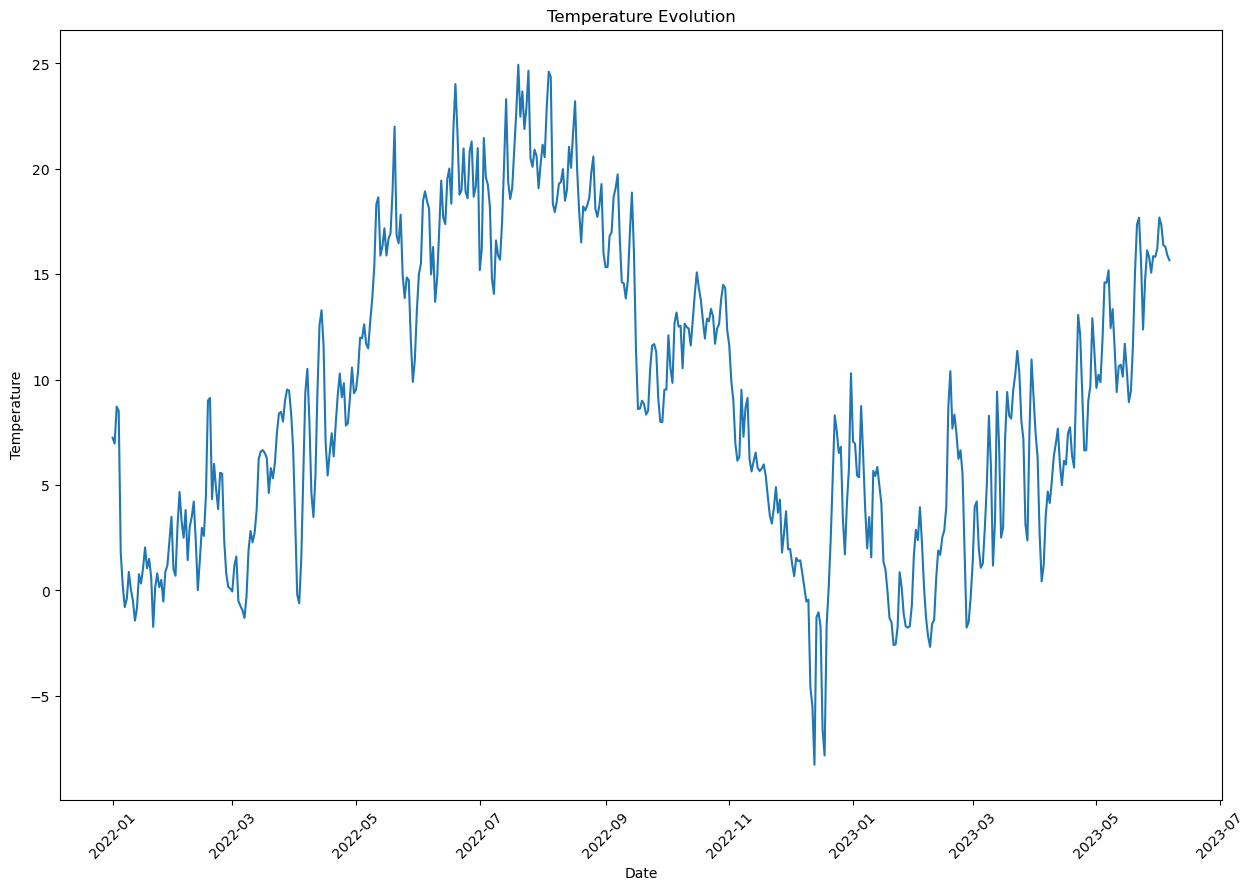

In [9]:
#Let's plot the temperature evolution in Munich
plt.figure(figsize=(15, 10))
plt.plot(df['date'], df['avg_temperature'])


# Customizing the plot
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Temperature Evolution')
plt.xticks(rotation=45)

# Display the plot
plt.show()

## <a id='toc4_2_'></a>[Checking for stationarity in the mean](#toc0_)

In [10]:
#We check for stationarity
result = adfuller(df['avg_temperature'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

# Tests
s = 365
d = ndiffs(df['avg_temperature'], alpha = 0.05, test='adf')  # regular differences?
D = nsdiffs(df['avg_temperature'], m = s, test='ocsb') # # seasonal differences?

print("Regular differences: ", d)
print('Seasonal differences:', D)

ADF Statistic: -1.8915297489797134
p-value: 0.33605621580186285
Regular differences:  1
Seasonal differences: 0


As we can see, our p-value is bigger than our treshold, 0.05, so we have to apply a difference and check again, in order to make our data stationary

In [11]:
# Differencing to make the data stationary
df['diff_temperature'] = df['avg_temperature'].diff().fillna(0)

# Check for stationarity after differencing
result_diff = adfuller(df['diff_temperature'])
print("ADF Statistic (after differencing):", result_diff[0])
print("p-value (after differencing):", result_diff[1])

ADF Statistic (after differencing): -14.38116642518879
p-value (after differencing): 9.147893368843569e-27


Now, our data is stationary, so we can further proceed

In [12]:
# Splitting the data into train and test sets
train, test = train_test_split(df, test_size=0.2, shuffle=False)

## <a id='toc4_3_'></a>[Checking Correlation and Autocorrelation](#toc0_)

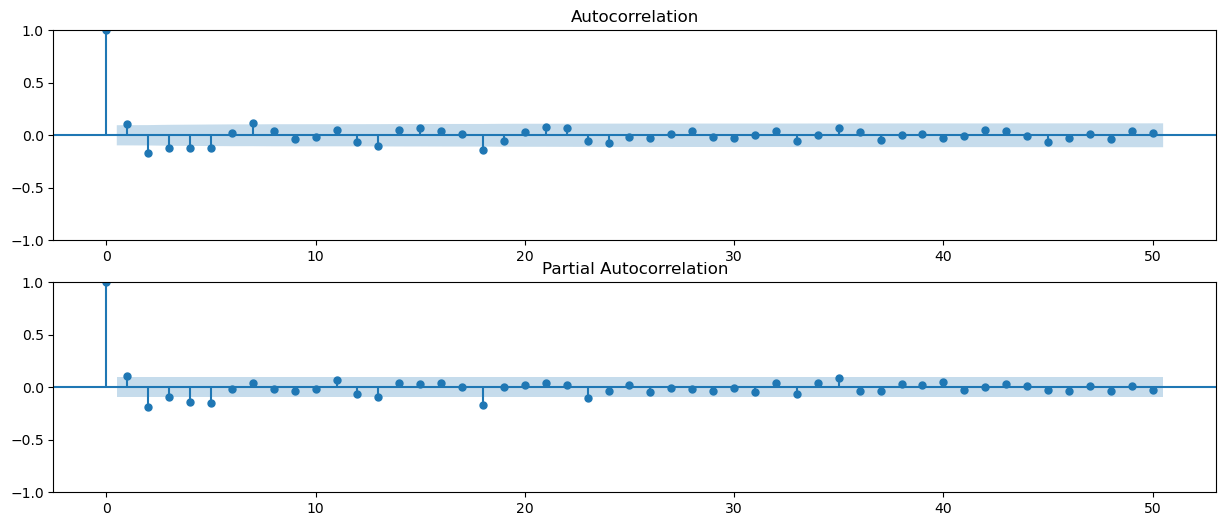

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

nlags = 50 # play with this parameter

# ValueError: Can only compute partial correlations for lags up to 50% of the sample size.

fig, ax = plt.subplots(2,1, figsize = (15,6))

plot_acf(train['diff_temperature'], lags = nlags, ax=ax[0])
plot_pacf(train['diff_temperature'], lags = nlags, method="ols", ax=ax[1])
plt.show()

## <a id='toc4_4_'></a>[Applying ARIMA](#toc0_)

In [14]:
#Apply an auto_arima model

#Alfonso's code crashes kernel
#model = pmdarima.auto_arima(train['diff_temperature'], seasonal=True, m=365, trace=True, error_action='ignore', suppress_warnings=True)

# <a id='toc5_'></a>[Integer constrained optimization apply to our demand (pyomo)](#toc0_)

## <a id='toc5_1_'></a>[Functions](#toc0_)

We make custom functions to retrieve our demand for our desired products. Since it has to be stochastic, we call a random integer on a range of values depending on three ranges of temperature

- Range cold <10 C
- Range medium 10 - 20 C
- Range hot >20C

The demand for the products will be different 

In [15]:
df.head()

,date,avg_temperature,diff_temperature
0,2022-01-01,7.245833,0.000000
1,2022-01-02,6.966667,-0.279167
2,2022-01-03,8.720833,1.754167
3,2022-01-04,8.516667,-0.204167
4,2022-01-05,1.800000,-6.716667


In [16]:
def get_demands_by_temperature(temperature_celsius):
    global wine_demand
    global ice_cream_demand
    global coffee_demand
    
    if temperature_celsius <= 10:
        wine_demand = random.randint(70, 90)
        ice_cream_demand = random.randint(1, 10)
        coffee_demand = random.randint(50, 70)
    elif temperature_celsius > 10 and temperature_celsius <= 20:
        wine_demand = random.randint(20, 40)
        ice_cream_demand = random.randint(15, 25)
        coffee_demand = random.randint(70, 90)
    elif temperature_celsius > 20:
        wine_demand = random.randint(1, 10)
        ice_cream_demand = random.randint(70, 90)
        coffee_demand = random.randint(30, 50)

    return wine_demand, ice_cream_demand, coffee_demand

In [17]:
df.tail()

,date,avg_temperature,diff_temperature
517,2023-06-02,17.337500,-0.354167
518,2023-06-03,16.375000,-0.962500
519,2023-06-04,16.300000,-0.075000
520,2023-06-05,15.891667,-0.408333
521,2023-06-06,15.662500,-0.229167


Here we calculate the historical demand for the year and a half previosuly retrieved from the API

In [18]:
# Apply the function to the DataFrame and create new columns for demand
df[['wine_demand', 'ice_cream_demand', 'coffee_demand']] = df['avg_temperature'].apply(lambda x: pd.Series(get_demands_by_temperature(x)))

# Display the updated DataFrame
print(df)

          date  avg_temperature  diff_temperature  wine_demand  \
0   2022-01-01         7.245833          0.000000           81   
1   2022-01-02         6.966667         -0.279167           79   
2   2022-01-03         8.720833          1.754167           84   
3   2022-01-04         8.516667         -0.204167           90   
4   2022-01-05         1.800000         -6.716667           80   
..         ...              ...               ...          ...   
517 2023-06-02        17.337500         -0.354167           34   
518 2023-06-03        16.375000         -0.962500           27   
519 2023-06-04        16.300000         -0.075000           36   
520 2023-06-05        15.891667         -0.408333           32   
521 2023-06-06        15.662500         -0.229167           28   

     ice_cream_demand  coffee_demand  
0                   9             70  
1                   1             51  
2                   5             67  
3                   5             68  
4           

In [25]:
# input a date and get the demand for coffee, icecream and wine
def get_demand_by_date(date):
    global wine_demand
    global ice_cream_demand
    global coffee_demand
    
    
    # get the row that matches the date
    row = df.loc[df['date'] == date]
    
    # get the demand values from the row
    wine_demand = row['wine_demand'].values[0]
    ice_cream_demand = row['ice_cream_demand'].values[0]
    coffee_demand = row['coffee_demand'].values[0]
    
    #print "The demand for (date) wine is", wine_demand and so on
    print("The demand for wine on", date, "is", wine_demand)
    print("The demand for ice cream on", date, "is", ice_cream_demand)
    print("The demand for coffee on", date, "is", coffee_demand)
    
    
    return wine_demand, ice_cream_demand, coffee_demand

## Knowing the demand for an specific day in the past

In [20]:
get_demand_by_date('2023-05-25')

The demand for wine on 2023-05-25 is 33
The demand for ice cream on 2023-05-25 is 15
The demand for coffee on 2023-05-25 is 85


(33, 15, 85)

Function returns prints and also the new variables which will be fed bellow into our Pyomo model

## <a id='toc6_'></a>[Pyomo model Pipeline](#toc0_)

In [24]:
# Create a concrete model
model = pyo.ConcreteModel()

We set the bounds and initialize our three products variables with the demand from the previous function above

In [26]:
# create three variables for hot_wine, coffee and ice_cream with bounds between 0 and 40 which must be random
model.hot_wine = pyo.Var(within=pyo.NonNegativeReals, bounds=(0,100), initialize= wine_demand)
model.coffee = pyo.Var(within=pyo.NonNegativeReals, bounds=(0,100), initialize= coffee_demand)
model.ice_cream = pyo.Var(within=pyo.NonNegativeReals, bounds=(0,100), initialize= ice_cream_demand)

In [27]:
#define the objective function
model.obj = pyo.Objective(expr = 2*model.hot_wine + 3*model.coffee + model.ice_cream, sense = maximize)

In [28]:
#show the objective function
model.pprint()

3 Var Declarations
    coffee : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :    89 :   100 : False : False : NonNegativeReals
    hot_wine : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :    28 :   100 : False : False : NonNegativeReals
    ice_cream : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :    20 :   100 : False : False : NonNegativeReals

1 Objective Declarations
    obj : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : maximize : 2*hot_wine + 3*coffee + ice_cream

4 Declarations: hot_wine coffee ice_cream obj


In [29]:
#capacity constraint for hot_wine and ice_cream and coffee
model.hot_wine_con = pyo.Constraint(expr = model.hot_wine <= 120)
model.coffee_con = pyo.Constraint(expr = model.coffee <= 200)
model.ice_cream_con = pyo.Constraint(expr = model.ice_cream <= 70)

In [30]:
#demand constrains for hot_wine, coffee and ice_cream
model.hot_wine_demand_con = pyo.Constraint(expr = model.hot_wine <= (wine_demand))
model.coffee_con2 = pyo.Constraint(expr = model.coffee <= (coffee_demand))
model.ice_cream_con2 = pyo.Constraint(expr = model.ice_cream <= (ice_cream_demand))

In [32]:
instance = model.create_instance()  # Create a concrete instance of the model

# <a id='toc7_'></a>[Pyomo Recommendations for Cafe owner](#toc0_)

In [33]:
#create different solvers and solve the model
opt = SolverFactory('cbc')
results = opt.solve(instance) # solves and updates instance
instance.display() # display solution
  
# <a id='toc8_'></a>[print the values of the variables](#toc0_)
print("The value of hot_wine is: " + str(pyo.value(instance.hot_wine)))
print("The value of coffee is: " + str(pyo.value(instance.coffee)))
print("The value of ice_cream is: " + str(pyo.value(instance.ice_cream)))
  
# <a id='toc9_'></a>[print the values of the objective function](#toc0_)
print("The value of the objective function is: " + str(pyo.value(instance.obj)))

Model unknown

  Variables:
    hot_wine : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  28.0 :   100 : False : False : NonNegativeReals
    coffee : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  89.0 :   100 : False : False : NonNegativeReals
    ice_cream : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  20.0 :   100 : False : False : NonNegativeReals

  Objectives:
    obj : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True : 343.0

  Constraints:
    hot_wine_con : Size=1
        Key  : Lower : Body : Upper
        None :  None : 28.0 : 120.0
    coffee_con : Size=1
        Key  : Lower : Body : Upper
        None :  None : 89.0 : 200.0
    ice_cream_con : Size=1
        Key  : Lower : Body : Upper
        None :  None : 20.0 :  70.0
    hot_wine_demand_con : Size=1
        Ke

In [34]:
#use  using AbstractModel.create_instance() or AbstractScalarVar.construct() to create a concrete instance of the model
opt = SolverFactory('glpk') #select solver
results = opt.solve(instance) #solve the problem
instance.display() #display the results
# Print the results of the optimization problem
print("The value of hot_wine is: " + str(pyo.value(instance.hot_wine)))
print("The value of coffee is: " + str(pyo.value(instance.coffee)))
print("The value of ice_cream is: " + str(pyo.value(instance.ice_cream)))
print("The value of the objective function is: " + str(pyo.value(instance.obj)))

Model unknown

  Variables:
    hot_wine : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  28.0 :   100 : False : False : NonNegativeReals
    coffee : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  89.0 :   100 : False : False : NonNegativeReals
    ice_cream : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  20.0 :   100 : False : False : NonNegativeReals

  Objectives:
    obj : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True : 343.0

  Constraints:
    hot_wine_con : Size=1
        Key  : Lower : Body : Upper
        None :  None : 28.0 : 120.0
    coffee_con : Size=1
        Key  : Lower : Body : Upper
        None :  None : 89.0 : 200.0
    ice_cream_con : Size=1
        Key  : Lower : Body : Upper
        None :  None : 20.0 :  70.0
    hot_wine_demand_con : Size=1
        Ke

==================================END OF NOTEBOOK=================================================